<div style="display:fill;
            border-radius:12px;
            background-color:lightblue;
            font-size:200%;
            letter-spacing:0.5px;
            padding:10px;
            color:black;
            border-style: solid;
            border-color: blue;
            border-width: thick;
            text-align:center;">
<b>
 GROUP 1 PROJECT WORK
 <br><br>
 Brain tumor detection 🧠🔍 from MRI images using <br><br>
    Deep Convolutional Network  </b></div>

* [1.0 Import Packages](#1.0)
* [2.0 Rearrange Images into Training, Validation and Testing](#2.0)
* [3.0 Show Number of Images Per Category Label ](#3.0)
* [4.0 Show Sample Images of Each Label](#4.0)
* [5.0 Show Augmented Images, That Can Reduce Overfitting](#5.0)
* [6.0 Apply Image Augmentation using Image Data Generator ](#6.0)
* [7.0 Get Transfer Learning Model - MobileNetV2](#7.0)
* [8.0 Building Deep Neural Network Architecture with MobileNetV2](#8.0)
* [9.0 Fine Tuning Transfer Learning Model](#9.0)
* [10.0 Evaluation on Unseen Data](#10.0)
* [11.0 Visualise Predictions on Unseen Data](#11.0)
* [12.0 What Computer see during training convolutional images](#12.0)
* [13.0 Test Your Own Images](#13.0)

# <b>1.0 <span style='color:red'>|</span> Import Packages </b> <a class="anchor" id="1.0"></a>

**let's import useful packages that will be used in this notebook**

In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, TextArea


ModuleNotFoundError: No module named 'sklearn'

In [3]:
os.getcwd()

'C:\\Users\\mawuk'

**change directory**

In [4]:
# Set the base directory
base_dir ='C:\\Users\\mawuk\\tumor'


**get sample dataframe with class labels**

In [4]:
# Read the dataset
df = pd.read_csv(os.path.join(base_dir, 'Brain_Tumor.csv'))[['Image', 'Class']]
display(df.head())
print(df.shape)


,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


(3762, 2)


In [30]:
df = pd.read_csv("Brain_Tumor.csv")
display(df.head())
print(df.shape)

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


(3762, 15)


In [31]:
df = pd.read_csv("Brain_Tumor.csv")[['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation']]
display(df.head())


,Image,Class,Mean,Variance,Standard Deviation
0,Image1,0,6.535339,619.587845,24.891522
1,Image2,0,8.749969,805.957634,28.389393
2,Image3,1,7.341095,1143.808219,33.820234
3,Image4,1,5.958145,959.711985,30.979219
4,Image5,0,7.315231,729.540579,27.010009


# <b>2.0 <span style='color:red'>|</span> Rearrange Images into Training, Validation and Testing </b> <a class="anchor" id="2.0"></a>

**Split files into training, validation and testing. We are using training and validation files when training the model. And we will using testing files to evaluate the final model. <br> Training: 0.8 proportion <br> Validation: 0.1 proportion <br> Testing: 0.1 proportion**

In [5]:
# Split the dataset into training, validation, and testing sets
def split_size(df, size):
    return int(size * len(df))

train_labels = df['Class'].values[:split_size(df, 0.8)]
train_file_names = df['Image'].values[:split_size(df, 0.8)]

val_labels = df['Class'].values[split_size(df, 0.8):split_size(df, 0.9)]
val_file_names = df['Image'].values[split_size(df, 0.8):split_size(df, 0.9)]

test_labels = df['Class'].values[split_size(df, 0.9):]
test_file_names = df['Image'].values[split_size(df, 0.9):]


In [6]:
# Split data into arrays based on labels
def split_array_labels(arr_image, arr_label):
    arr_image_0 = arr_image[np.where(arr_label == 0)]
    arr_image_1 = arr_image[np.where(arr_label == 1)]
    return {'0': arr_image_0, '1': arr_image_1}

train_arr_dict = split_array_labels(train_file_names, train_labels)
val_arr_dict = split_array_labels(val_file_names, val_labels)
test_arr_dict = split_array_labels(test_file_names, test_labels)


**Create empyty directories of training, validation and testing**

In [7]:
# Create directories for data split
def create_empty_directories(base_dir):
    check_exist_path = os.path.join(base_dir, '_MODELLING')
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
    
    for label in ['0', '1']:
        training_dir = os.path.join(base_dir, '_MODELLING', 'training', label)
        validation_dir = os.path.join(base_dir, '_MODELLING', 'validation', label)
        testing_dir = os.path.join(base_dir, '_MODELLING', 'testing', label)
        
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        os.makedirs(testing_dir)
    print(f"Created empty training, validation, and testing directories")

create_empty_directories(base_dir)


Created empty training, validation, and testing directories


**Split images by copying and pasting into their respective directories**

In [8]:
# Copy images to respective directories based on data split
def split_data(SOURCE_DIR, train_arr_dict, val_arr_dict, test_arr_dict):
    for label in tqdm(['0', '1']):
        for file_name in train_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain_Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'training', label, file_name)
            shutil.copyfile(source, destination)

        for file_name in val_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain_Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'validation', label, file_name)
            shutil.copyfile(source, destination)
        
        for file_name in test_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain_Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'testing', label, file_name)
            shutil.copyfile(source, destination)
    print(f"Created training, validation, and testing directories containing images")

split_data(base_dir, train_arr_dict, val_arr_dict, test_arr_dict)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.68s/it]

Created training, validation, and testing directories containing images


# <b>3.0 <span style='color:red'>|</span> Show Number of Images Per Category Label </b> <a class="anchor" id="3.0"></a>

In [33]:
base_dir  = 'C:\\Users\\jansa\\proj_conda\\tumor\\_MODELLING'
os.chdir(base_dir)

mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

,Tran Test,Labels,Number of Items
0,testing,0,138
1,testing,1,239
2,training,0,1822
3,training,1,1187
4,validation,0,119
5,validation,1,257


# <b>4.0 <span style='color:red'>|</span> Show Sample Images of Each Label </b> <a class="anchor" id="4.0"></a>

**Visualising some images of each label**

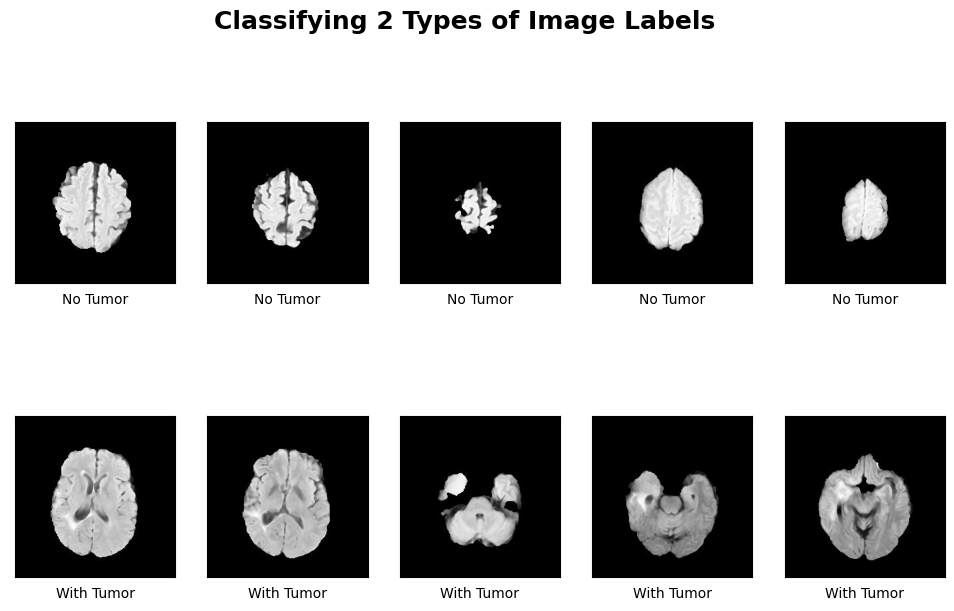

In [34]:
# get first 10 images for visualisation
vis_images = vis_images[:10]
vis_labels = vis_labels[:10]

plt.figure(figsize=(12,7))
for i in range(len(vis_labels)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    
    if vis_labels[i] == '0':
        my_label = 'No Tumor'
    elif vis_labels[i] == '1':
        my_label = 'With Tumor'
    
    plt.xlabel(my_label)
    plt.suptitle(f"Classifying 2 Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

# <b>5.0 <span style='color:red'>|</span> Show Augmented Images, That Can Reduce Overfitting </b> <a class="anchor" id="5.0"></a>

In order to train neural networks that will be used in real-world applications, data augmentation is a crucial step. We can improve our model's ability to generalise and produce more precise predictions on data that it was not trained on by using data augmentation. <br>

Data augmentation will operate concurrently with the other layers of your application on-device and will receive GPU acceleration.

def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)


show_ImageDataGenerator(vis_images, vis_labels, image_index = 2)

# <b>6.0 <span style='color:red'>|</span> Apply Image Augmentation using Image Data Generator </b> <a class="anchor" id="6.0"></a>

In [9]:
# Set the image directories
base_dir = 'C:\\Users\\jansa\\proj_conda\\tumor'
training_dir = os.path.join(base_dir, '_MODELLING', 'training')
validation_dir = os.path.join(base_dir, '_MODELLING', 'validation')
testing_dir = os.path.join(base_dir, '_MODELLING', 'testing')

In [10]:
# Define data generators for training, validation, and testing

#train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
#)

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150, 150),
                                                       batch_size=32,
                                                       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(testing_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')


Found 3009 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


# <b>7.0 <span style='color:red'>|</span> Get Transfer Learning Model - MobileNetV2 </b> <a class="anchor" id="7.0"></a>

MobileNet-v2 is a convolutional neural network consisting of 53 layers deep. The ImageNet database contains a pretrained version of the network that has been trained on more than a million images [1]. The pretrained network can categorise photos into 1000 different object categories. It is good to have a good sense of initialisation of parameters. So we will freeze the top layers of MovileNetV2 first and train on the last output layers.

# <b>8.0 <span style='color:red'>|</span> Building Deep Neural Network Architecture </b> <a class="anchor" id="8.0"></a>

In [11]:
# Create the CNN model with dropout layers and Transfer Learning with MobileNetV2
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 512)               16384512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18643009 (71.12 MB)
Trainable params: 16385025 (62.50 MB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# Implement early stopping to mitigate overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


In [14]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[early_stopping])

95/95 [======================

Epoch 1/100
95/95 [==============================] - 52s 514ms/step - loss: 2.3901 - accuracy: 0.8305 - val_loss: 0.3945 - val_accuracy: 0.7899
Epoch 2/100
95/95 [==============================] - 39s 407ms/step - loss: 0.2406 - accuracy: 0.9076 - val_loss: 0.3465 - val_accuracy: 0.8457
Epoch 3/100
95/95 [==============================] - 41s 431ms/step - loss: 0.2396 - accuracy: 0.9103 - val_loss: 0.3165 - val_accuracy: 0.8936
Epoch 4/100
95/95 [==============================] - 46s 480ms/step - loss: 0.2124 - accuracy: 0.9219 - val_loss: 0.2700 - val_accuracy: 0.9016
Epoch 5/100
95/95 [==============================] - 45s 470ms/step - loss: 0.1634 - accuracy: 0.9325 - val_loss: 0.2571 - val_accuracy: 0.8883
Epoch 6/100
95/95 [==============================] - 45s 476ms/step - loss: 0.1879 - accuracy: 0.9279 - val_loss: 0.3246 - val_accuracy: 0.8511
Epoch 7/100
95/95 [==============================] - 45s 478ms/step - loss: 0.1423 - accuracy: 0.9428 - val_loss: 0.2582 - val_accuracy:

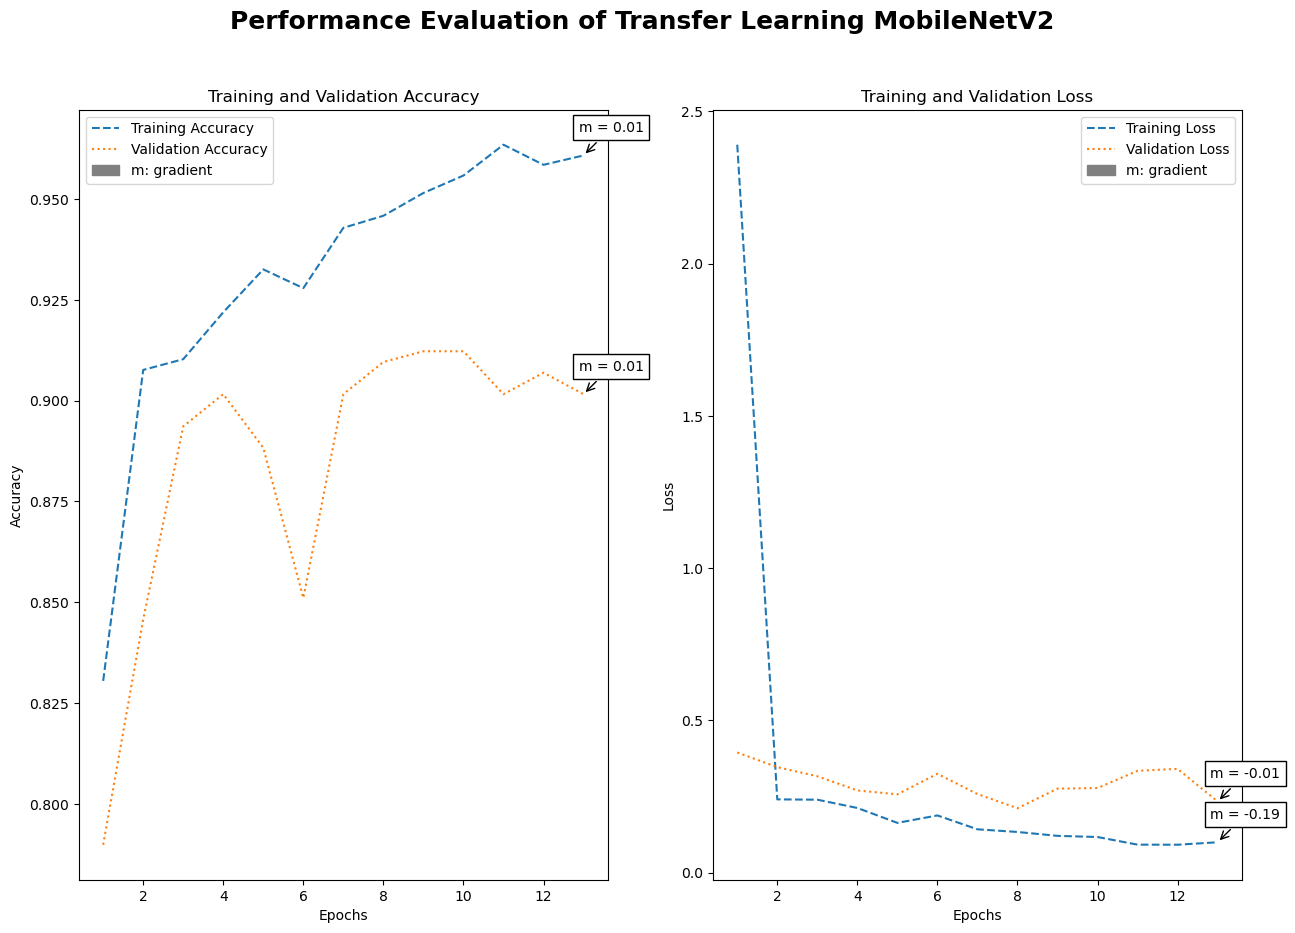

In [15]:
# Visualize training and validation metrics using the vis_evaluation function
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy']) + 1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)

        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                                  xybox=(20, 20),
                                  xycoords='data',
                                  boxcoords="offset points",
                                  arrowprops=dict(arrowstyle="->"))

        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)

    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

history_dict_1 = history.history
vis_evaluation(history_dict_1, 'Transfer Learning MobileNetV2')


# <b>9.0 <span style='color:red'>|</span> Fine Tuning Transfer Learning Model </b> <a class="anchor" id="9.0"></a>

In [16]:
# Fine-tuning the model
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [19]:
fine_tune_history = model.fit(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=100,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator))



Epoch 13/100
95/95 [==============================] - 57s 601ms/step - loss: 0.2407 - accuracy: 0.9219 - val_loss: 0.2509 - val_accuracy: 0.8989
Epoch 14/100
95/95 [==============================] - 64s 669ms/step - loss: 0.1811 - accuracy: 0.9402 - val_loss: 0.2598 - val_accuracy: 0.8910
Epoch 15/100
95/95 [==============================] - 67s 703ms/step - loss: 0.1189 - accuracy: 0.9521 - val_loss: 0.2849 - val_accuracy: 0.8883
Epoch 16/100
95/95 [==============================] - 66s 696ms/step - loss: 0.1351 - accuracy: 0.9531 - val_loss: 0.2574 - val_accuracy: 0.9016
Epoch 17/100
95/95 [==============================] - 65s 683ms/step - loss: 0.0734 - accuracy: 0.9711 - val_loss: 0.2883 - val_accuracy: 0.8936
Epoch 18/100
95/95 [==============================] - 62s 649ms/step - loss: 0.0842 - accuracy: 0.9664 - val_loss: 0.3021 - val_accuracy: 0.8936
Epoch 19/100
95/95 [==============================] - 60s 630ms/step - loss: 0.0650 - accuracy: 0.9744 - val_loss: 0.3133 - val_ac

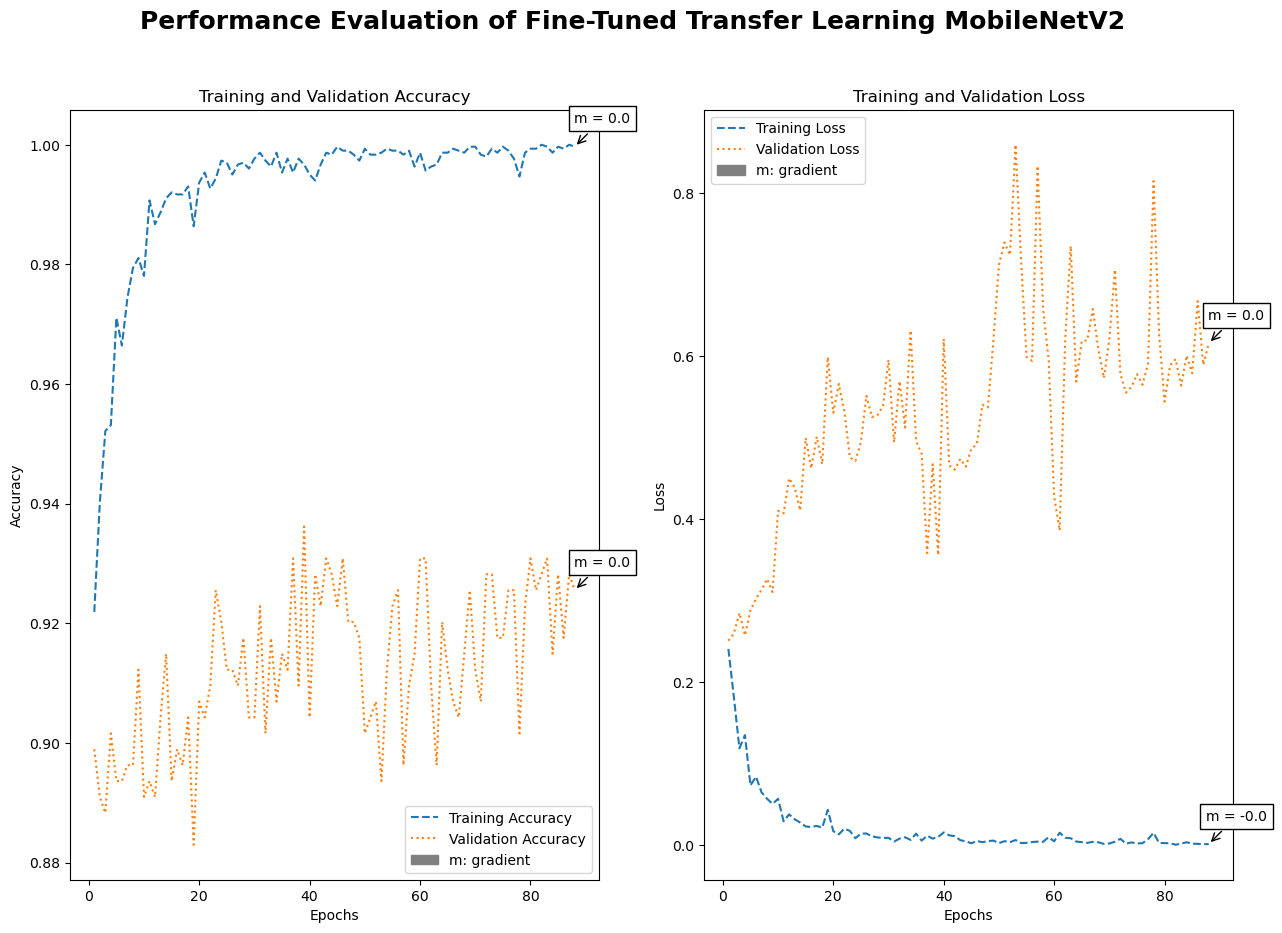

In [20]:
# Visualize fine-tuning results
history_dict_2 = fine_tune_history.history
vis_evaluation(history_dict_2, 'Fine-Tuned Transfer Learning MobileNetV2')


# <b>10.0 <span style='color:red'>|</span> Evaluation on Unseen Data </b> <a class="anchor" id="10.0"></a>

In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', accuracy)


12/12 [==============================] - 5s 388ms/step - loss: 0.4358 - accuracy: 0.9443
Test accuracy: 0.9442970752716064


# <b>11.0 <span style='color:red'>|</span> Visualise Predictions on Unseen Data

1/1 [==============================] - 0s 37ms/step


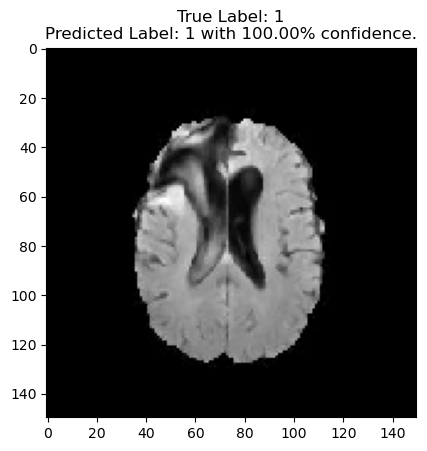

1/1 [==============================] - 0s 60ms/step


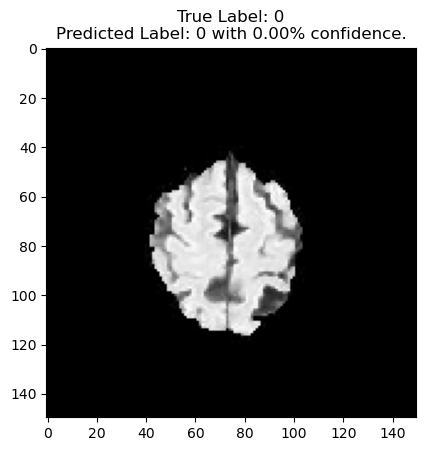

1/1 [==============================] - 0s 60ms/step


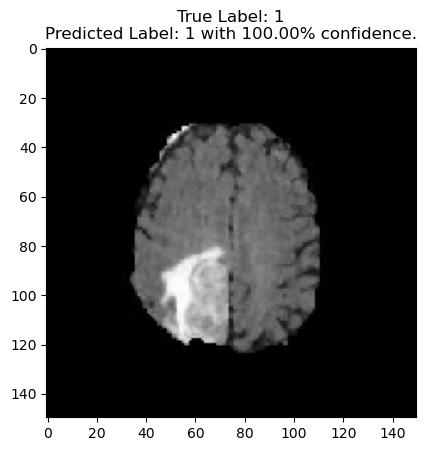

1/1 [==============================] - 0s 65ms/step


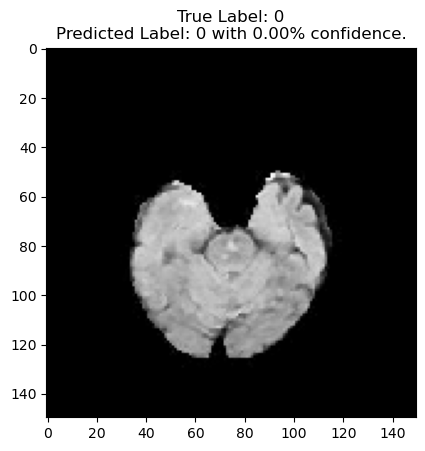

1/1 [==============================] - 0s 48ms/step


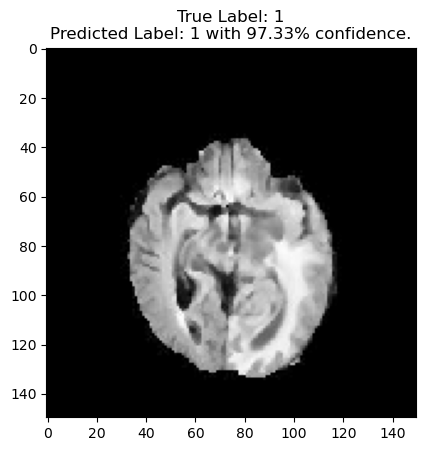

1/1 [==============================] - 0s 39ms/step


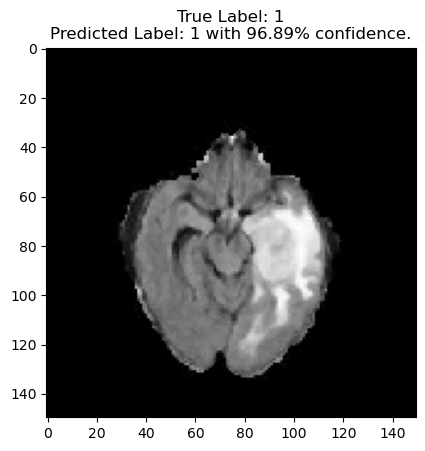

1/1 [==============================] - 0s 67ms/step


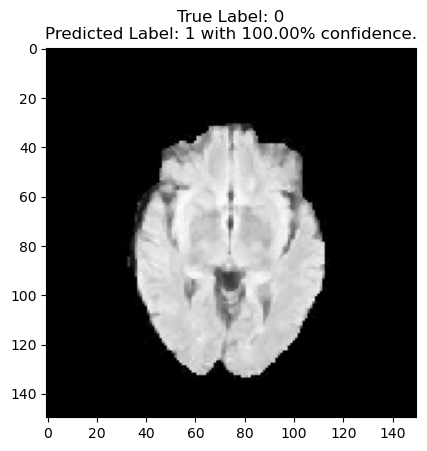

1/1 [==============================] - 0s 54ms/step


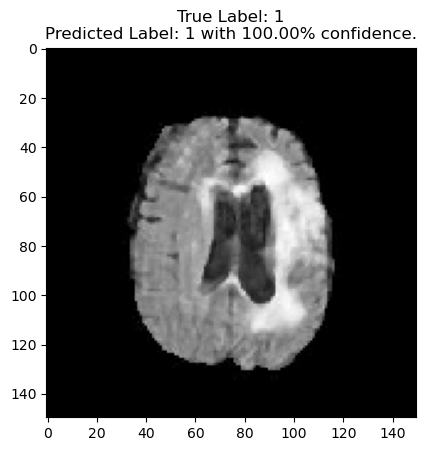

1/1 [==============================] - 0s 50ms/step


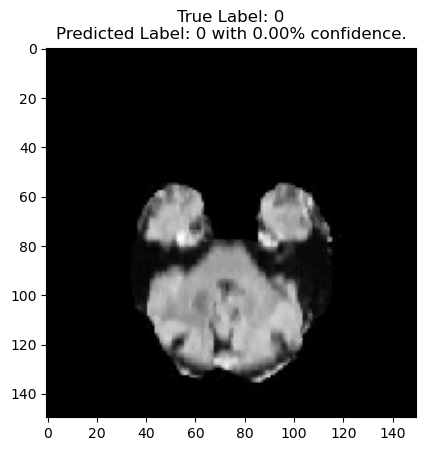

1/1 [==============================] - 0s 70ms/step


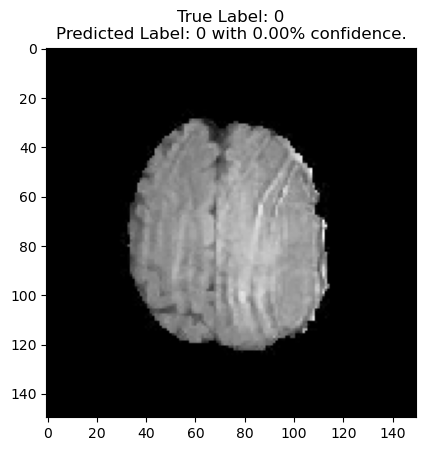

1/1 [==============================] - 0s 49ms/step


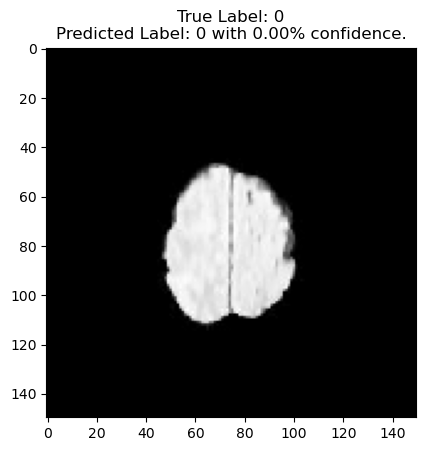

1/1 [==============================] - 0s 72ms/step


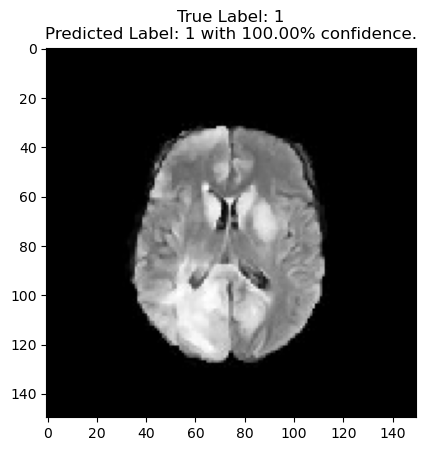

1/1 [==============================] - 0s 50ms/step


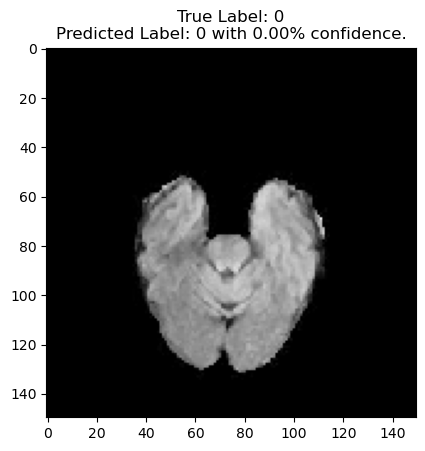

1/1 [==============================] - 0s 43ms/step


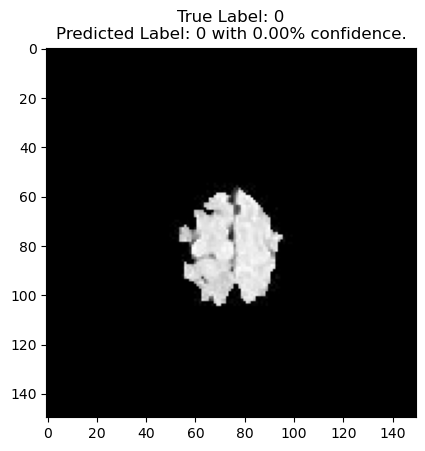

1/1 [==============================] - 0s 48ms/step


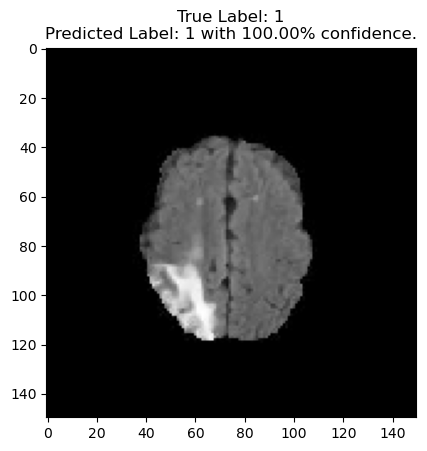

1/1 [==============================] - 0s 54ms/step


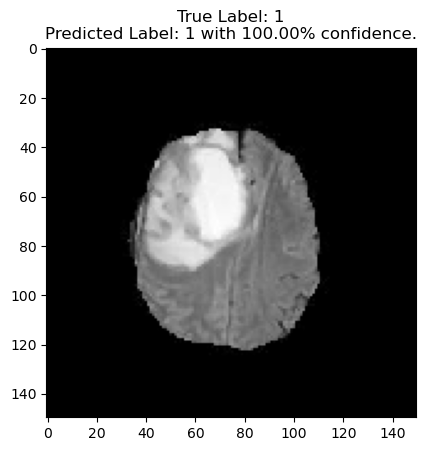

1/1 [==============================] - 0s 64ms/step


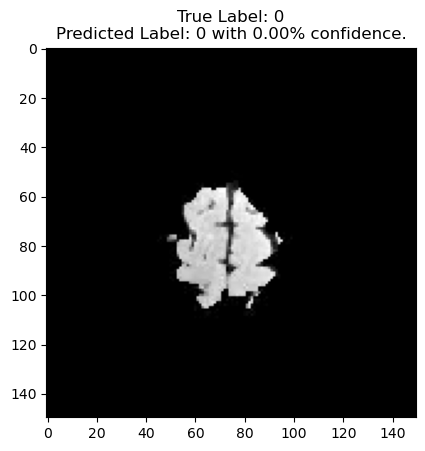

1/1 [==============================] - 0s 67ms/step


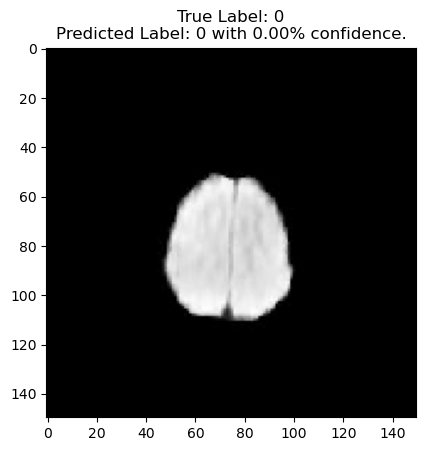

1/1 [==============================] - 0s 72ms/step


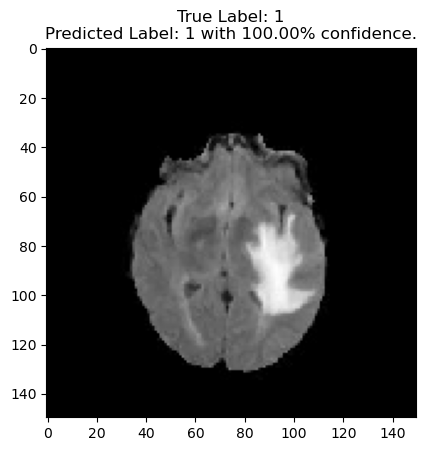

1/1 [==============================] - 0s 44ms/step


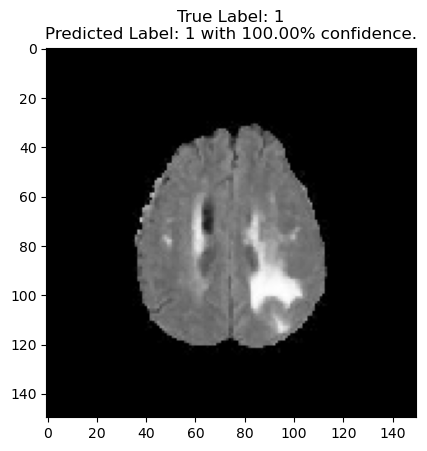

In [39]:
# Make predictions on sample images
base_dir = 'C:\\Users\\jansa\\proj_conda\\tumor'
selected_paths = []
selected_labels = []

testing_path_0 = os.path.join(base_dir, '_MODELLING', 'testing', '0')
for x in random.sample(os.listdir(testing_path_0), 10):
    selected_paths.append(os.path.join(testing_path_0, x))
    selected_labels.append(0)

testing_path_1 = os.path.join(base_dir, '_MODELLING', 'testing', '1')
for x in random.sample(os.listdir(testing_path_1), 10):
    selected_paths.append(os.path.join(testing_path_1, x))
    selected_labels.append(1)

X, y = shuffle(selected_paths, selected_labels, random_state=0)

for vis_image, y_true in zip(X, y):
    img = tf.keras.preprocessing.image.load_img(vis_image, target_size=(150, 150))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)[0]
    predicted_label = 1 if prediction > 0.5 else 0
    
    plt.title(f'True Label: {y_true}\nPredicted Label: {predicted_label} with {100 * prediction[0]:.2f}% confidence.')
    plt.imshow(img)
    plt.show()

# <b>13.0 <span style='color:red'>|</span> Test Your Own Images </b> <a class="anchor" id="13.0"></a>

1/1 [==============================] - 0s 39ms/step


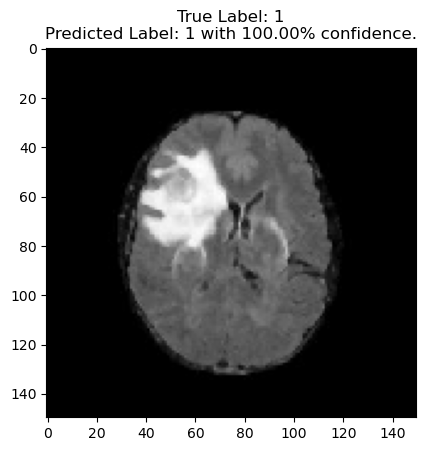

1/1 [==============================] - 0s 43ms/step


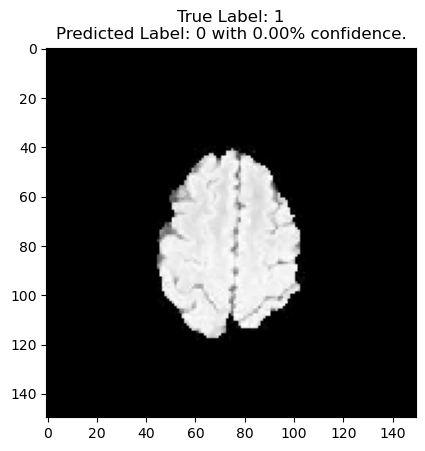

In [28]:
# Test the model with your own images
def test_with_own_images(model, image_paths):
    for img_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        img_arr = tf.keras.preprocessing.image.img_to_array(img)
        img_arr = img_arr / 255.0
        img_arr = np.expand_dims(img_arr, axis=0)

        prediction = model.predict(img_arr)[0]
        predicted_label = 1 if prediction > 0.5 else 0

        plt.title(f'True Label: {y_true}\nPredicted Label: {predicted_label} with {100 * prediction[0]:.2f}% confidence.')
        plt.imshow(img)
        plt.show()

# Replace 'YOUR_IMAGE_PATHS' with a list of your own image paths
image_paths = ['C:\\Users\\jansa\\proj_conda\\brain2\\_MODELLING\\testing\\1\\Image3488.jpg',
               'C:\\Users\\jansa\\proj_conda\\brain2\\_MODELLING\\testing\\0\\Image3429.jpg']

test_with_own_images(model, image_paths)

<div style="display:fill;
            border-radius:12px;
            background-color:pearl;
            font-size:150%;
            letter-spacing:0.5px;
            padding:10px;
            color:black;
            border-style: solid;
            border-color: blue;
            border-width: thick;
            text-align:center;">
<b>
 The end. <br></b></div>